In [ ]:
# In case "Disconnect and Delete Runtime" isn't working
# !kill -9 -1

In [2]:
import os
import sys

# Upgrade pip, just in case...
!{sys.executable} -m pip install --upgrade -q pip

# Install requests for downloading data.
!{sys.executable} -m pip install --upgrade -q requests
!{sys.executable} -m pip install --upgrade -q pandas

import requests

tcia_utils_text = requests.get("https://github.com/kirbyju/TCIA_Notebooks/raw/main/tcia_utils.py")
with open('tcia_utils.py', 'wb') as f:
    f.write(tcia_utils_text.content)

import tcia_utils as tcia

     |████████████████████████████████| 2.1 MB 32.5 MB/s 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 89.4 MB/s eta 0:00:00


In [3]:

from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import Adam

## Load, process, and label the cancer data 

In [4]:
# Download a "Shared Cart" that has been previously 
#    created via the NBIA webset 
#    (https://nbia.cancerimagingarchive.net)
cartName = "nbia-47881669847357616" # Our lung cancer data's first subject

# retrieve cart metadata
cart_data = tcia.getSharedCart(cartName)

# download the series_uids list and return dataframe of metadata
df = tcia.downloadSeries(cart_data)

# display dataframe
display(df)

Calling...  https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=nbia-47881669847357616
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021332276911485641315
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.6655.2359.257508444832901632590301540805
Download Complete: 2 Series Instance UIDs (scans).


,Series UID,Collection,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class UID,Number of Images,File Size,Series Number,License Name,License URL,Annotation Size
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021...,Lung-PET-CT-Dx,https://doi.org/10.7937/TCIA.2020.NNC2-0461,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,1.2.840.10008.5.1.4.1.1.2,64,33750912,3.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.257508444832...,Lung-PET-CT-Dx,https://doi.org/10.7937/TCIA.2020.NNC2-0461,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,1.2.840.10008.5.1.4.1.1.2,64,33750912,2.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0


In [5]:
# Install itk for DICOM I/O and for reading DICOM into an itkImage 
#   that manages all DICOM field values, include acquistion details 
#   such as voxel image, image orientation, and image directions
#   which are critical to image processing and display
!{sys.executable} -m pip install --upgrade --pre -q "itk==5.3rc4.post3"

# Additionally we'll install numpy and torch to explore a variety of 
#    image data structures
!{sys.executable} -m pip install -q torch
!{sys.executable} -m pip install -q numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 45.8 MB/s eta 0:00:00


In [6]:
# Include ITK for DICOM reading
import itk

# Numpy for numpy.arrays
import numpy as np

# Torch for torch.tensors
import torch

In [7]:
# Install and import PyDICOM, then store file paths in list

!{sys.executable} -m pip install pydicom

import pydicom as di 
import os
from os import listdir
os.rename("tciaDownload", "tciaDownloadCancer")
PathDicom_cancer = "tciaDownloadCancer"
DCMFiles_cancer = [] 
for dirName, subdirList, fileList in os.walk(PathDicom_cancer):
    for filename in fileList:
        if ".dcm" in filename.lower():
            DCMFiles_cancer.append(os.path.join(dirName,filename))
print("Number of (.dcm) files =", len(DCMFiles_cancer))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.8 MB/s eta 0:00:00
Number of (.dcm) files = 128


In [8]:
ds_cancer=di.dcmread(DCMFiles_cancer[0])
print(ds_cancer)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6655.2359.214867730999461949717018158340
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008, 0012) Instance Creation Date              DA: '20070404'
(0008, 0013) Instance Creation Time              TM: '190151'
(0008, 0016) SOP Class UID 

In [ ]:
ds_cancer.PixelRepresentation

0

In [ ]:
ds_cancer.BitsStored

12

In [9]:
# Extract pixel data from image files, rescale, resize, and simulate 3 channels for RGB

X_cancer = []
y_cancer = []
for k in DCMFiles_cancer:
    Image = di.read_file(k,force=True)
    if Image.pixel_array.shape == (512,512):
      monochrome_data = Image.pixel_array
      ds = di.dcmread(k)
      if ds.PixelRepresentation == 0:
        # Unsigned integers
        monochrome_data = monochrome_data/4095
      else:
        # Signed integers
        monochrome_data = (monochrome_data +2048)/4095
      monochrome_data = cv2.resize(monochrome_data,(224,224))
      rgb_data = np.stack([monochrome_data, monochrome_data, monochrome_data])
      rgb_data = rgb_data.transpose((1, 2, 0))
      X_cancer.append(rgb_data)
      y_cancer.append(1) # 0 = covid data, 1 = cancer data

In [36]:
matrix = np.random.rand(2,2)
matrix

array([[0.33518584, 0.57112508],
       [0.76256482, 0.54669783]])

In [37]:
matrix + 2

array([[2.33518584, 2.57112508],
       [2.76256482, 2.54669783]])

In [38]:
matrix / 3

array([[0.11172861, 0.19037503],
       [0.25418827, 0.18223261]])

### Skip over the rest of this section

In [ ]:
X_cancer

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 

In [ ]:
type(X_cancer)

list

In [ ]:
type(X_cancer[0])

numpy.ndarray

In [ ]:
X_cancer[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [ ]:
X_cancer[0].shape

(512, 512, 3)

In [ ]:
X_cancer_array = np.array(X_cancer)
print(X_cancer_array.ndim)

4


In [ ]:
X_cancer_array.shape

(128, 512, 512, 3)

In [ ]:
X_cancer_array[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [ ]:
# Use the data frame to find the Series UID where the Modality is CT
dicom_data_dir = "tciaDownloadCancer/"
ct_series_uid = df.at[df.Modality.eq('CT').idxmax(), 'Series UID']
dicom_ct_dir = os.path.join(dicom_data_dir, ct_series_uid)

# Load and sort the DICOM data into a volume - since no series_uid is
#    specified with this read command, it will load the first series in the directory.
dicom_image_large = itk.imread(dicom_ct_dir, itk.F)

# To save time for this demo, we subsample the image in the x and y dimensions
new_spacing = list(dicom_image_large.GetSpacing())
new_spacing[:2] = [x*3 for x in new_spacing[:2]]
new_size = list(dicom_image_large.GetLargestPossibleRegion().GetSize())
new_size[:2] = [x//3 for x in new_size[:2]]
dicom_image = itk.resample_image_filter(Input=dicom_image_large,
                                        output_spacing=new_spacing, 
                                        output_origin=dicom_image_large.GetOrigin(), 
                                        output_direction=dicom_image_large.GetDirection(),
                                        size=new_size)
print(f"New spacing = {new_spacing}")
print(f"New size = {new_size}")

RuntimeError: ignored

## Do it again for COVID data

In [10]:
cartName = "nbia-6761669942417940" # Covid data

# retrieve cart metadata
cart_data = tcia.getSharedCart(cartName)

# download the series_uids list and return dataframe of metadata
df = tcia.downloadSeries(cart_data)

# display dataframe
display(df)

Calling...  https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=nbia-6761669942417940
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.99.1071.14850676509103506699400577275960
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.99.1071.21083349907841416087078944245719
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.99.1071.22090542070462647745743105373525
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.99.1071.22366983673254100505145504004129
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class UID,Number of Images,File Size,Series Number,License Name,License URL,Annotation Size
0,1.3.6.1.4.1.14519.5.2.1.99.1071.14850676509103...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,2.0,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,2,1314900,1.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
1,1.3.6.1.4.1.14519.5.2.1.99.1071.21083349907841...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,Body 3.000 CE,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,118,160721790,7.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
2,1.3.6.1.4.1.14519.5.2.1.99.1071.22090542070462...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,Body 3.000 CE,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,89,121222124,6.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
3,1.3.6.1.4.1.14519.5.2.1.99.1071.22366983673254...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,Lung 1.0 CE,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,596,314916466,4.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
4,1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,Body 5.0 CE,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,120,63405602,2.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
5,1.3.6.1.4.1.14519.5.2.1.99.1071.85179820664090...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,Lung 5.0 CE,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,120,63405842,3.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0


In [11]:
os.rename("tciaDownload", "tciaDownloadCovid")
PathDicom_covid = "tciaDownloadCovid"
DCMFiles_covid = [] 
for dirName, subdirList, fileList in os.walk(PathDicom_covid):
    for filename in fileList:
        if ".dcm" in filename.lower():
            DCMFiles_covid.append(os.path.join(dirName,filename))
print("Number of (.dcm) files =", len(DCMFiles_covid))

Number of (.dcm) files = 1045


In [12]:
# Extract pixel data from image files, rescale, resize, and simulate 3 channels for RGB data

X_covid = []
y_covid = []
for k in DCMFiles_covid:
    Image = di.read_file(k,force=True)
    if Image.pixel_array.shape == (512,512):
      monochrome_data = Image.pixel_array
      ds = di.dcmread(k)
      if ds.PixelRepresentation == 0:
        # Unsigned integers
        monochrome_data = monochrome_data/4095
      else:
        # Signed integers
        monochrome_data = (monochrome_data +2048)/4095
      monochrome_data = cv2.resize(monochrome_data,(224,224))
      rgb_data = np.stack([monochrome_data, monochrome_data, monochrome_data])
      rgb_data = rgb_data.transpose((1, 2, 0))
      X_covid.append(rgb_data)
      y_covid.append(0) # 0 = covid data, 1 = cancer data

### Skip the rest of this section

In [ ]:
DCMFiles_covid

['tciaDownloadCovid/1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294220615667317485469/1-068.dcm',
 'tciaDownloadCovid/1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294220615667317485469/1-094.dcm',
 'tciaDownloadCovid/1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294220615667317485469/1-062.dcm',
 'tciaDownloadCovid/1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294220615667317485469/1-056.dcm',
 'tciaDownloadCovid/1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294220615667317485469/1-095.dcm',
 'tciaDownloadCovid/1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294220615667317485469/1-051.dcm',
 'tciaDownloadCovid/1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294220615667317485469/1-058.dcm',
 'tciaDownloadCovid/1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294220615667317485469/1-082.dcm',
 'tciaDownloadCovid/1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294220615667317485469/1-090.dcm',
 'tciaDownloadCovid/1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294220615667317485469/1-009.dcm',
 'tciaDownloadCovid/1.3.6.1.4.

In [ ]:
DCMFiles_covid[0]

'tciaDownloadCovid/1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294220615667317485469/1-068.dcm'

In [ ]:
di.read_file(DCMFiles_covid[0]).pixel_array

array([[-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       ...,
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048]], dtype=int16)

In [ ]:
ds_covid=di.dcmread(DCMFiles_covid[0])
print(ds_covid)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.99.1071.32429683672552795007484389427679
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.99.1071.3242968

In [ ]:
ds_covid.PixelRepresentation

1

In [ ]:
ds_covid.BitsStored

16

In [ ]:
-2**(ds_covid.BitsStored - 1)

-32768

In [ ]:
X_covid

[array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]), array([[[0., 0., 0.],
         [0., 0., 0.],
         [

In [ ]:
type(X_covid)

list

In [ ]:
len(X_covid)

836

In [ ]:
type(X_covid[0])

numpy.ndarray

In [ ]:
X_covid[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [ ]:
test1 = (X_covid[0]+2048)/4095
test1

array([[[0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221],
        ...,
        [0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221]],

       [[0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221],
        ...,
        [0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221]],

       [[0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221],
        ...,
        [0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221]],

       ...,

       [[0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221],
        [0.5001221, 0.5001221, 0.5001221],
        ...,
        [0.5001221, 0.5001

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
test2 = scaler.fit_transform(X_covid[0])

ValueError: ignored

In [ ]:
for n in X_covid:
  print(n.shape)

In [ ]:
X_covid_array = np.array(X_covid)
print(X_covid_array.ndim)

In [ ]:
X_covid_array.shape

In [ ]:
# Use the data frame to find the Series UID where the Modality is CT
dicom_data_dir = "tciaDownloadCovid/"
ct_series_uid = df.at[df.Modality.eq('CT').idxmax(), 'Series UID']
dicom_ct_dir = os.path.join(dicom_data_dir, ct_series_uid)

# Load and sort the DICOM data into a volume - since no series_uid is
#    specified with this read command, it will load the first series in the directory.
dicom_image_large = itk.imread(dicom_ct_dir, itk.F)

# To save time for this demo, we subsample the image in the x and y dimensions
new_spacing = list(dicom_image_large.GetSpacing())
new_spacing[:2] = [x*3 for x in new_spacing[:2]]
new_size = list(dicom_image_large.GetLargestPossibleRegion().GetSize())
new_size[:2] = [x//3 for x in new_size[:2]]
dicom_image = itk.resample_image_filter(Input=dicom_image_large,
                                        output_spacing=new_spacing, 
                                        output_origin=dicom_image_large.GetOrigin(), 
                                        output_direction=dicom_image_large.GetDirection(),
                                        size=new_size)
print(f"New spacing = {new_spacing}")
print(f"New size = {new_size}")

## Train test split

In [13]:
# Convert to array 
X_cancer = np.array(X_cancer)
X_covid = np.array(X_covid)

print(X_cancer.ndim)
print(X_covid.ndim)

X = np.concatenate((X_cancer, X_covid),axis=0)
y = np.concatenate((y_cancer,y_covid),axis=0)

# Split into training and testing sets for both types of images
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)


# X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(
    # X_cancer, y_cancer, test_size=0.2)
# X_covid_train, X_covid_test, y_covid_train, y_covid_test = train_test_split(
    # X_covid, y_covid, test_size=0.2)


4
4


In [13]:
X_cancer.shape

(128, 224, 224, 3)

In [14]:
X_covid.shape

(836, 224, 224, 3)

In [ ]:
# Merge sets for both types of images
# X_train = np.concatenate((X_cancer_train, X_covid_train), axis=0)
# X_test = np.concatenate((X_cancer_test, X_covid_test), axis=0)
# y_train = np.concatenate((y_cancer_train, y_covid_train), axis=0)
# y_test = np.concatenate((y_cancer_test, y_covid_test), axis=0)

In [14]:
# Preprocess inputs
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [15]:
X_test

array([[[[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ]],

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ]],

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ]],

        ...,

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -1

In [16]:
# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

## VGG19

In [17]:
# Create model
vgg_model = VGG19(weights="imagenet")

574710816/574710816 [==============================] - 25s 0us/step


In [18]:
vgg_model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [20]:
predictions = vgg_model.predict(X_train)
print('Predicted:', decode_predictions(predictions, top=3))

35363/35363 [==============================] - 0s 0us/step
Predicted: [[('n03729826', 'matchstick', 0.07637764), ('n01930112', 'nematode', 0.05722486), ('n03196217', 'digital_clock', 0.03141439)], [('n03729826', 'matchstick', 0.07646109), ('n01930112', 'nematode', 0.057001796), ('n03196217', 'digital_clock', 0.031407084)], [('n03729826', 'matchstick', 0.07638886), ('n01930112', 'nematode', 0.057467192), ('n03196217', 'digital_clock', 0.031466864)], [('n03729826', 'matchstick', 0.07651388), ('n01930112', 'nematode', 0.056914676), ('n03196217', 'digital_clock', 0.03142135)], [('n03729826', 'matchstick', 0.07644412), ('n01930112', 'nematode', 0.05701031), ('n03196217', 'digital_clock', 0.031405818)], [('n03729826', 'matchstick', 0.076393634), ('n01930112', 'nematode', 0.057060834), ('n03196217', 'digital_clock', 0.03135975)], [('n03729826', 'matchstick', 0.07638935), ('n01930112', 'nematode', 0.057099767), ('n03196217', 'digital_clock', 0.031389184)], [('n03729826', 'matchstick', 0.076512

## Transfer Learning

In [33]:
# Build new model generalizing from VGG so that we can predict our own classes

inputs = vgg_model.input
outputs = vgg_model.output

outputs = Flatten(name="flatten2")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs, outputs)

for layer in vgg_model.layers:
    layer.trainable = False

learning_rate = 0.1

optimizer = Adam(learning_rate)

model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy']
)

In [34]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.1>

In [32]:
# model.optimizer.learning_rate # This is showing default lr for optimizer='adam'

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [ ]:
# Compare model summaries
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
# Add image augmentation preprocessing (random rotations, shifts, flips)
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [21]:
# training config:
epochs = 500
batch_size = 32

In [35]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
24/24 [==============================] - 11s 441ms/step - loss: 0.4428 - accuracy: 0.8457 - val_loss: 0.3877 - val_accuracy: 0.8756
Epoch 2/500
24/24 [==============================] - 10s 420ms/step - loss: 0.4007 - accuracy: 0.8651 - val_loss: 0.3787 - val_accuracy: 0.8756
Epoch 3/500
24/24 [==============================] - 10s 414ms/step - loss: 0.4050 - accuracy: 0.8651 - val_loss: 0.3826 - val_accuracy: 0.8756
Epoch 4/500
24/24 [==============================] - 10s 420ms/step - loss: 0.4012 - accuracy: 0.8651 - val_loss: 0.3776 - val_accuracy: 0.8756
Epoch 5/500
24/24 [==============================] - 10s 418ms/step - loss: 0.4000 - accuracy: 0.8651 - val_loss: 0.3823 - val_accuracy: 0.8756
Epoch 6/500
24/24 [==============================] - 10s 417ms/step - loss: 0.4025 - accuracy: 0.8651 - val_loss: 0.3803 - val_accuracy: 0.8756
Epoch 7/500
24/24 [==============================] - 10s 417ms/step - loss: 0.4047 - accuracy: 0.8651 - val_loss: 0.3760 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
# Save Model and Weights
model.save('vgg19_ct_2.h5')
model.save_weights('vgg19_weights_ct_2.hdf5')

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

7/7 [==============================] - 1s 194ms/step


In [ ]:
print(y_pred)

[[0.01955551 0.98044443]
 [0.14260156 0.85739845]
 [0.01839118 0.9816088 ]
 [0.7872749  0.2127251 ]
 [0.31144968 0.68855035]
 [0.01190871 0.98809123]
 [0.01640128 0.9835987 ]
 [0.74978274 0.25021726]
 [0.2698837  0.7301163 ]
 [0.01337981 0.9866202 ]
 [0.18205653 0.81794345]
 [0.21157406 0.788426  ]
 [0.01024506 0.989755  ]
 [0.2462709  0.75372905]
 [0.7512689  0.24873105]
 [0.8418399  0.15816009]
 [0.0371342  0.96286577]
 [0.00535267 0.9946473 ]
 [0.32129237 0.67870766]
 [0.03945255 0.96054745]
 [0.25411624 0.74588376]
 [0.01085862 0.98914135]
 [0.7008026  0.29919738]
 [0.01887328 0.9811267 ]
 [0.49567512 0.50432485]
 [0.3198605  0.6801395 ]
 [0.99269086 0.00730912]
 [0.9986834  0.00131664]
 [0.9986834  0.00131664]
 [0.9986834  0.00131664]
 [0.99269086 0.00730913]
 [0.99269086 0.00730912]
 [0.9986834  0.00131664]
 [0.9927043  0.00729571]
 [0.99269086 0.00730912]
 [0.9926865  0.00731346]
 [0.9931443  0.00685578]
 [0.99745935 0.00254072]
 [0.99269086 0.00730912]
 [0.99269086 0.00730912]


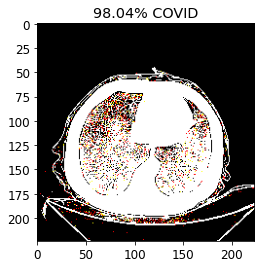

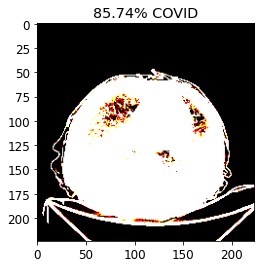

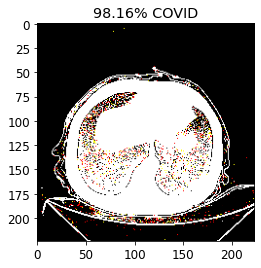

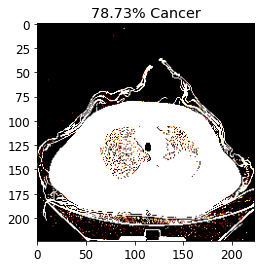

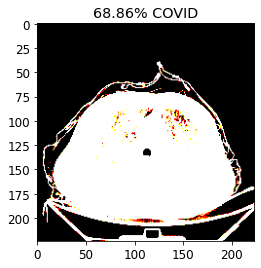

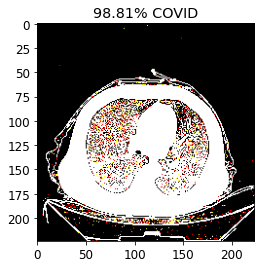

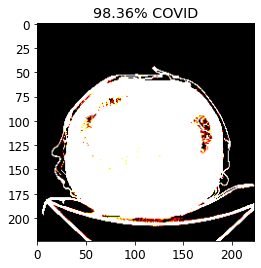

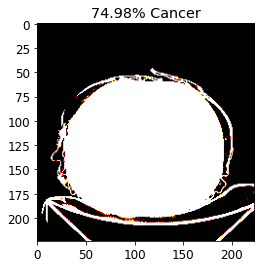

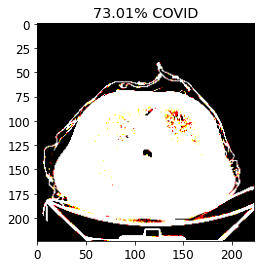

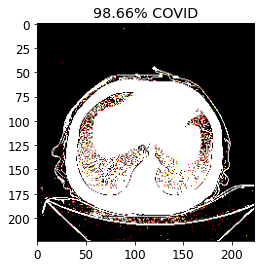

In [ ]:
prediction=y_pred[:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Cancer')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

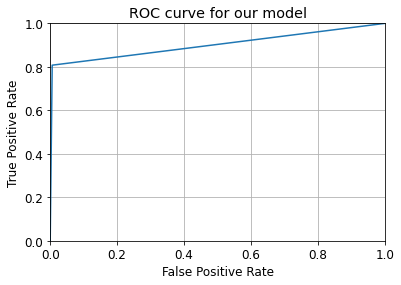

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
!cp vgg19_ct.h5 /content/drive/MyDrive
!cp vgg19_weights_ct.hdf5 /content/drive/MyDrive

Confusion Matrix without Normalization


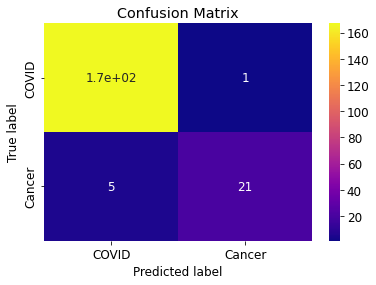

Confusion Matrix with Normalized Values


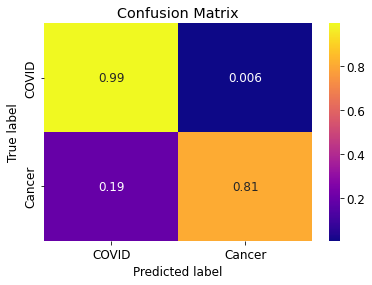

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','Cancer']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       168
           1       0.95      0.81      0.88        26

    accuracy                           0.97       194
   macro avg       0.96      0.90      0.93       194
weighted avg       0.97      0.97      0.97       194



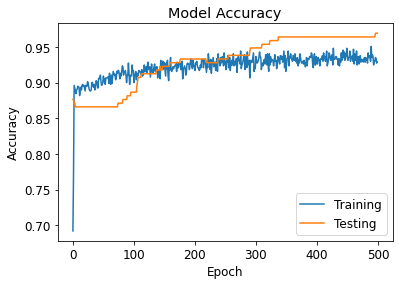

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()

In [ ]:
!cp vgg_ct_accuracy.png /content/drive/MyDrive